In [142]:
import json
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.pyplot as plt
#import statsmodels.api as sm
import scipy
import statsmodels.api as sm

In [143]:
%matplotlib inline
plt.style.use('default')

In [144]:
data_dir = ".\\data"
img_dir = ".\\img"

output_links_lookup = os.path.join(data_dir, "pavement_links_to_or_links.csv")
output_or_roads = os.path.join(data_dir, "open_roads_clean.shp")

output_road_network = os.path.join(data_dir, "open-roads RoadLink betcen diffs.gpkg")
road_nodes = os.path.join(data_dir, "open-roads RoadNode Intersect Within simplify angles.shp")
pave_nodes = os.path.join(data_dir, "pedNetworkNodes.shp")

output_pave_links = os.path.join(data_dir, "pednetworkLinksWithCentralities.gpkg")
output_pave_ex_diag_links = os.path.join(data_dir, "pednetworkLinksExDiagWithCentralities.gpkg")
output_pave_res_links = os.path.join(data_dir, "pednetworkLinksResWithCentralities.gpkg")
output_pave_res_time_links = os.path.join(data_dir, "pednetworkLinksResTimeWithCentralities.gpkg")

output_network_figure_primal = os.path.join(img_dir, "disagg_pavement_networks_primal.png")
output_network_figure_dual = os.path.join(img_dir, "disagg_pavement_networks_dual.png")

# Load Data

In [145]:
gdfRoadBC = gpd.read_file(output_road_network)
gdfRoadNodes = gpd.read_file(road_nodes)
gdfPaveBC = gpd.read_file(output_pave_links)
gdfPaveExDiagBC = gpd.read_file(output_pave_ex_diag_links)
gdfPaveResBC = gpd.read_file(output_pave_res_links)

gdfPaveNodes = gpd.read_file(pave_nodes)

# Aggregate Centrality Comparison

## Rank Correnation

Compare road centre line centrality to aggregated pavement centrality values by calculating the rank corelation between links.

Additionally, perform related sampels ttest to check for significant differences between values.

In [146]:
gdfRoadBC['roadBCRank'] = gdfRoadBC['roadBCsum'].rank() # RCL centrality values
gdfRoadBC['paveBCsumRank'] = gdfRoadBC['paveBCsum'].rank() # Aggreagted UPN centrality values
gdfRoadBC['paveRBCsumRank'] = gdfRoadBC['paveRBCsum'].rank() # Aggregated RUPN centrality values
gdfRoadBC['paveExDBCsumRank'] = gdfRoadBC['paveExDBCsum'].rank() # Aggregated CPN centrality values

In [147]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'paveBCsumRank']].dropna().values
sr_rcl_vs_upn = scipy.stats.spearmanr(data, axis=0)

data = gdfRoadBC.loc[:, ['roadBCRank', 'paveRBCsumRank']].dropna().values
sr_rcl_vs_rupn = scipy.stats.spearmanr(data, axis=0)

data = gdfRoadBC.loc[:, ['roadBCRank', 'paveExDBCsumRank']].dropna().values
sr_rcl_vs_cpn = scipy.stats.spearmanr(data, axis=0)

In [148]:
# Print the values
print("RCL vs UPN: {}".format(sr_rcl_vs_upn))
print("RCL vs RUPN: {}".format(sr_rcl_vs_rupn))
print("RCL vs CPN: {}".format(sr_rcl_vs_cpn))

RCL vs UPN: SpearmanrResult(correlation=0.9177902891836096, pvalue=0.0)
RCL vs RUPN: SpearmanrResult(correlation=0.9199488263574706, pvalue=0.0)
RCL vs CPN: SpearmanrResult(correlation=0.9580092191211864, pvalue=0.0)


### Explaining difference between case with diagonal links and case without

When diagonal links not included in the network, meaning that crossings between sides of the road must occur at junctions, higher correlation between road link centrality and pavement link centrality is observed.

This suggests that a pavement network representation that restricts pedestrian crossings to junctions more closely matches a road centre line representation. Diagonal links traverse space differently to pavement links that run approximately parallel to the road centre line. This difference produces betweenness centrality values that are less well correlated with road link centralities.

Does this mean that a pavement network representation would produce different flows on road links?

The rank correlation coefficient confirms the regression analysis results above. When diagonal links are excluded the centrality of the pavement network links more closely matches the centrality of the road network links.

However, the correlation is high in both cases, suggesting that were pedestrians to follow desire line more frequently flows predicted by betweenness centrality would differ only slightly.

# Disaggregate Centrality Comparison

Compare the difference between a pavement links centrallity value and the mean centrality value averaged over all pavement links associated with a road link.

Use t-test to test for significate differences between betweenness centrality difference values between pedestrian network representations.

In [149]:
# Convert to numeric data type
gdfPaveBC['paveBCdiff_pv'] = gdfPaveBC['paveBCdiff_pv'].astype(float)
gdfPaveResBC['paveRBCdiff_pv'] = gdfPaveResBC['paveRBCdiff_pv'].astype(float)
gdfPaveExDiagBC['paveExDBCdiff_pv'] = gdfPaveExDiagBC['paveExDBCdiff_pv'].astype(float)

In [150]:
# Filter out outliers

# There is one particularly high value in the UPN data (gdfPaveBC) for the 'paveBCdiff_pv' field. Upper quantile = 0.0022, max value = 0.11.

# Filtering out values 1.5 x higher than the top 0.9999 quantile removes this one data point.
upper_limit = gdfPaveBC['paveBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveBC.loc[ gdfPaveBC['paveBCdiff_pv']>upper_limit].index
print("UPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveBC.drop(index_to_drop, inplace=True)

upper_limit = gdfPaveResBC['paveRBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveResBC.loc[ gdfPaveResBC['paveRBCdiff_pv']>upper_limit].index
print("RUPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveResBC.drop(index_to_drop, inplace=True)

upper_limit = gdfPaveExDiagBC['paveExDBCdiff_pv'].quantile(0.9999) * 1.5
index_to_drop = gdfPaveExDiagBC.loc[ gdfPaveExDiagBC['paveExDBCdiff_pv']>upper_limit].index
print("RUPN: Excluding {} outliers".format(len(index_to_drop)))
gdfPaveExDiagBC.drop(index_to_drop, inplace=True)

UPN: Excluding 1 outliers
RUPN: Excluding 0 outliers
RUPN: Excluding 0 outliers


In [151]:
# Comparing means

# Assuming from imdependent samples
scipy.stats.ttest_ind(gdfPaveBC['paveBCdiff_pv'].dropna(), gdfPaveResBC['paveRBCdiff_pv'].dropna())
scipy.stats.ttest_ind(gdfPaveExDiagBC['paveExDBCdiff_pv'].dropna(), gdfPaveResBC['paveRBCdiff_pv'].dropna())
scipy.stats.ttest_ind(gdfPaveBC['paveBCdiff_pv'].dropna(), gdfPaveExDiagBC['paveExDBCdiff_pv'].dropna())

Ttest_indResult(statistic=-0.08735490138871363, pvalue=0.93039023209826)

In [152]:
data = pd.merge(gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']!='direct_cross', ['paveExDBCdiff_pv', 'pave_link_id']], gdfPaveResBC.loc[:, ['paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()

In [153]:
# Assuming related sampels - this is more approporaiate because we are comparing two values for the samme pavement link under different representations

data = pd.merge(gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']!='direct_cross', ['paveExDBCdiff_pv', 'pave_link_id']], gdfPaveResBC.loc[:, ['paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.ttest_rel( abs(data['paveExDBCdiff_pv']), abs(data['paveRBCdiff_pv'])))
print(abs(data['paveExDBCdiff_pv']).mean(), abs(data['paveRBCdiff_pv']).mean())

data = pd.merge(gdfPaveBC.loc[gdfPaveBC['linkType']!='direct_cross', ['paveBCdiff_pv', 'pave_link_id']], gdfPaveResBC.loc[:, ['paveRBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.ttest_rel( abs(data['paveBCdiff_pv']), abs(data['paveRBCdiff_pv']) ))
print(abs(data['paveBCdiff_pv']).mean(), abs(data['paveRBCdiff_pv']).mean())

data = pd.merge(gdfPaveBC.loc[gdfPaveBC['linkType']!='direct_cross', ['paveBCdiff_pv', 'pave_link_id']], gdfPaveExDiagBC.loc[:, ['paveExDBCdiff_pv', 'pave_link_id']], on='pave_link_id', how = 'inner').dropna()
print(scipy.stats.ttest_rel( abs(data['paveBCdiff_pv']), abs(data['paveExDBCdiff_pv']) ))
print(abs(data['paveBCdiff_pv']).mean(), abs(data['paveExDBCdiff_pv']).mean())


Ttest_relResult(statistic=-2.8662530471170005, pvalue=0.004165692436237892)
0.0024772945032146346 0.002558005253076253
Ttest_relResult(statistic=15.148948029787528, pvalue=2.1804524794651424e-51)
0.002743761345981512 0.002143721023227688
Ttest_relResult(statistic=15.642896044089285, pvalue=2.860985301914574e-54)
0.003604695837433559 0.0025168710034276613


In [154]:
# Means
print("CPN:{} +- {}".format(abs(gdfPaveExDiagBC['paveExDBCdiff_pv']).mean(), abs(gdfPaveExDiagBC['paveExDBCdiff_pv']).sem()))
print("RUPN:{} +- {}".format(abs(gdfPaveResBC['paveRBCdiff_pv']).mean(), abs(gdfPaveResBC['paveRBCdiff_pv']).sem()))
print("UPN:{} +- {}".format(abs(gdfPaveBC['paveBCdiff_pv']).mean(), abs(gdfPaveBC['paveBCdiff_pv']).sem()))

CPN:0.0024391718065550493 +- 5.1025503779498126e-05
RUPN:0.002066700589735359 +- 3.3946945385866064e-05
UPN:0.003230396298375625 +- 5.3798455831164666e-05


# Plot disaggregate values

By plotting the difference between a pavement link's centrality value and the average value for that road link we can visually inspect which side of the road shortest path flows bias and see whether these biases extend for multiple road links.

In [155]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

In [181]:
def road_network_figure(G, dict_node_pos, dict_edge_values, title, cmap_name = 'viridis', edge_width = 3, edge_alpha = 1):

    plt.style.use('dark_background')
    f, ax = plt.subplots(1,1,figsize = (15,15))

    ax = road_network_subfigure(ax, G, dict_node_pos, dict_edge_values, title, cmap_name = cmap_name, edge_width=edge_width, edge_alpha=edge_alpha)
    return f

def road_network_subfigure(ax, G, dict_node_pos, title, edge_color = 'red', edge_cmap = 'bwr', edge_width = 3, edge_alpha = 1, title_font = {'size': 12}, edge_vmin = 0, edge_vmax=1):

    nx.draw_networkx_nodes(G, dict_node_pos, ax = ax, nodelist=G.nodes(), node_color = 'grey', node_size = 1, alpha = 0.1)
    nx.draw_networkx_edges(G, dict_node_pos, ax = ax, edgelist=G.edges(), width = 3, edge_color = edge_color, edge_cmap=edge_cmap, alpha=edge_alpha, edge_vmin = edge_vmin, edge_vmax=edge_vmax)
    ax.set_title(title, fontdict = title_font, y = 0)
    ax.axis('off')
    return ax

def plot_disaggregate_bc_values_for_multiple_networks(dict_node_pos, zoom_bb, G_BCDiff, G_BCDiffRes, G_BCDiffExDi, BCDiff = 'paveBCdiff_pv', BCDiffRes = 'paveRBCdiff_pv', BCDiffExDi = 'paveExDBCdiff_pv', edge_alpha=1.0):
    
    # get edge data to color edges by
    bcdiff_data = np.array([d[-1] for d in  G_BCDiff.edges.data(BCDiff, default=0)])
    bcdiff_exdi_data = np.array([d[-1] for d in G_BCDiffExDi.edges.data(BCDiffExDi, default=0)])
    bcdiff_res_data = np.array([d[-1] for d in G_BCDiffRes.edges.data(BCDiffRes, default=0)])
    
    # bcdiff_data values excluded here because it contains a small number of large values that skew the normalisation for the colormap colormap
    all_values = np.concatenate([bcdiff_data, bcdiff_res_data, bcdiff_exdi_data])
    vmin = -1*max(abs(all_values))
    vmax = max(abs(all_values))

    f, axs = plt.subplots(1, 3, figsize = (50,20), sharey=False, sharex=False)

    road_network_subfigure(axs[0], G_BCDiffExDi, dict_node_pos, "Constrained\nPedestrian Network (CPN)", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    road_network_subfigure(axs[1], G_BCDiffRes, dict_node_pos, "Residential Unconstrained\nPedestrian Network (RUPN)", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    road_network_subfigure(axs[2], G_BCDiff, dict_node_pos, "Unconstrained\nPedestrian Network (UPN)", edge_color = bcdiff_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

    # Add rectangles indicating zoom area
    x1, y1, x2, y2 = zoom_bb
    axs[0].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))
    axs[1].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))
    axs[2].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))

    # Add colourbars
    smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = f.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
    cbar.ax.tick_params(labelsize=25)

    # Add inset
    axins = f.add_axes([0.27, 0.6, 0.07, 0.2])
    road_network_subfigure(axins, G_BCDiffExDi, dict_node_pos, "", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.axis('on')

    axins = f.add_axes([0.25*2, 0.6, 0.07, 0.2])
    road_network_subfigure(axins, G_BCDiffRes, dict_node_pos, "", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.axis('on')

    axins = f.add_axes([0.245*3, 0.6, 0.07, 0.2])
    road_network_subfigure(axins, G_BCDiff, dict_node_pos, "", edge_color = bcdiff_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = edge_alpha, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.axis('on')

    # Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

    _ = f.suptitle("Pedestrian edge centrality difference from road segment average", y = 0.95, fontsize=48, weight = 'bold')
    
    return f, axs


In [157]:
# Create graphs for each network representation
G_BCDiff = nx.Graph()
edges = gdfPaveBC.loc[ gdfPaveBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveBCdiff_pv']].dropna().values
G_BCDiff.add_weighted_edges_from(edges, weight = 'paveBCdiff_pv')

G_BCDiffExDi = nx.Graph()
edges = gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveExDBCdiff_pv']].dropna().values
G_BCDiffExDi.add_weighted_edges_from(edges, weight = 'paveExDBCdiff_pv')

G_BCDiffRes = nx.Graph()
edges = gdfPaveResBC.loc[gdfPaveResBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'paveRBCdiff_pv']].dropna().values
G_BCDiffRes.add_weighted_edges_from(edges, weight = 'paveRBCdiff_pv')

In [158]:
# Get ratio of study are height : width
study_area_bounds = gdfPaveBC.total_bounds
width = study_area_bounds[2] - study_area_bounds[0]
height = study_area_bounds[3] - study_area_bounds[1]

htow = height / width

In [159]:
# Using the geographical coordinates of the nodes when plotting them
points_pos = gdfPaveNodes.set_index('fid')
points_pos['x'] = points_pos['geometry'].map(lambda g: g.coords[0][0])
points_pos['y'] = points_pos['geometry'].map(lambda g: g.coords[0][1])
node_posistions = list(zip(points_pos['x'], points_pos['y']))
dict_node_pos = dict(zip(points_pos.index, node_posistions))

In [164]:
# Load zoom area
gdfZoom = gpd.read_file(os.path.join(data_dir, 'zoom_area2.shp'))
zoom_bb = gdfZoom.total_bounds

In [165]:
plt.style.use('default')

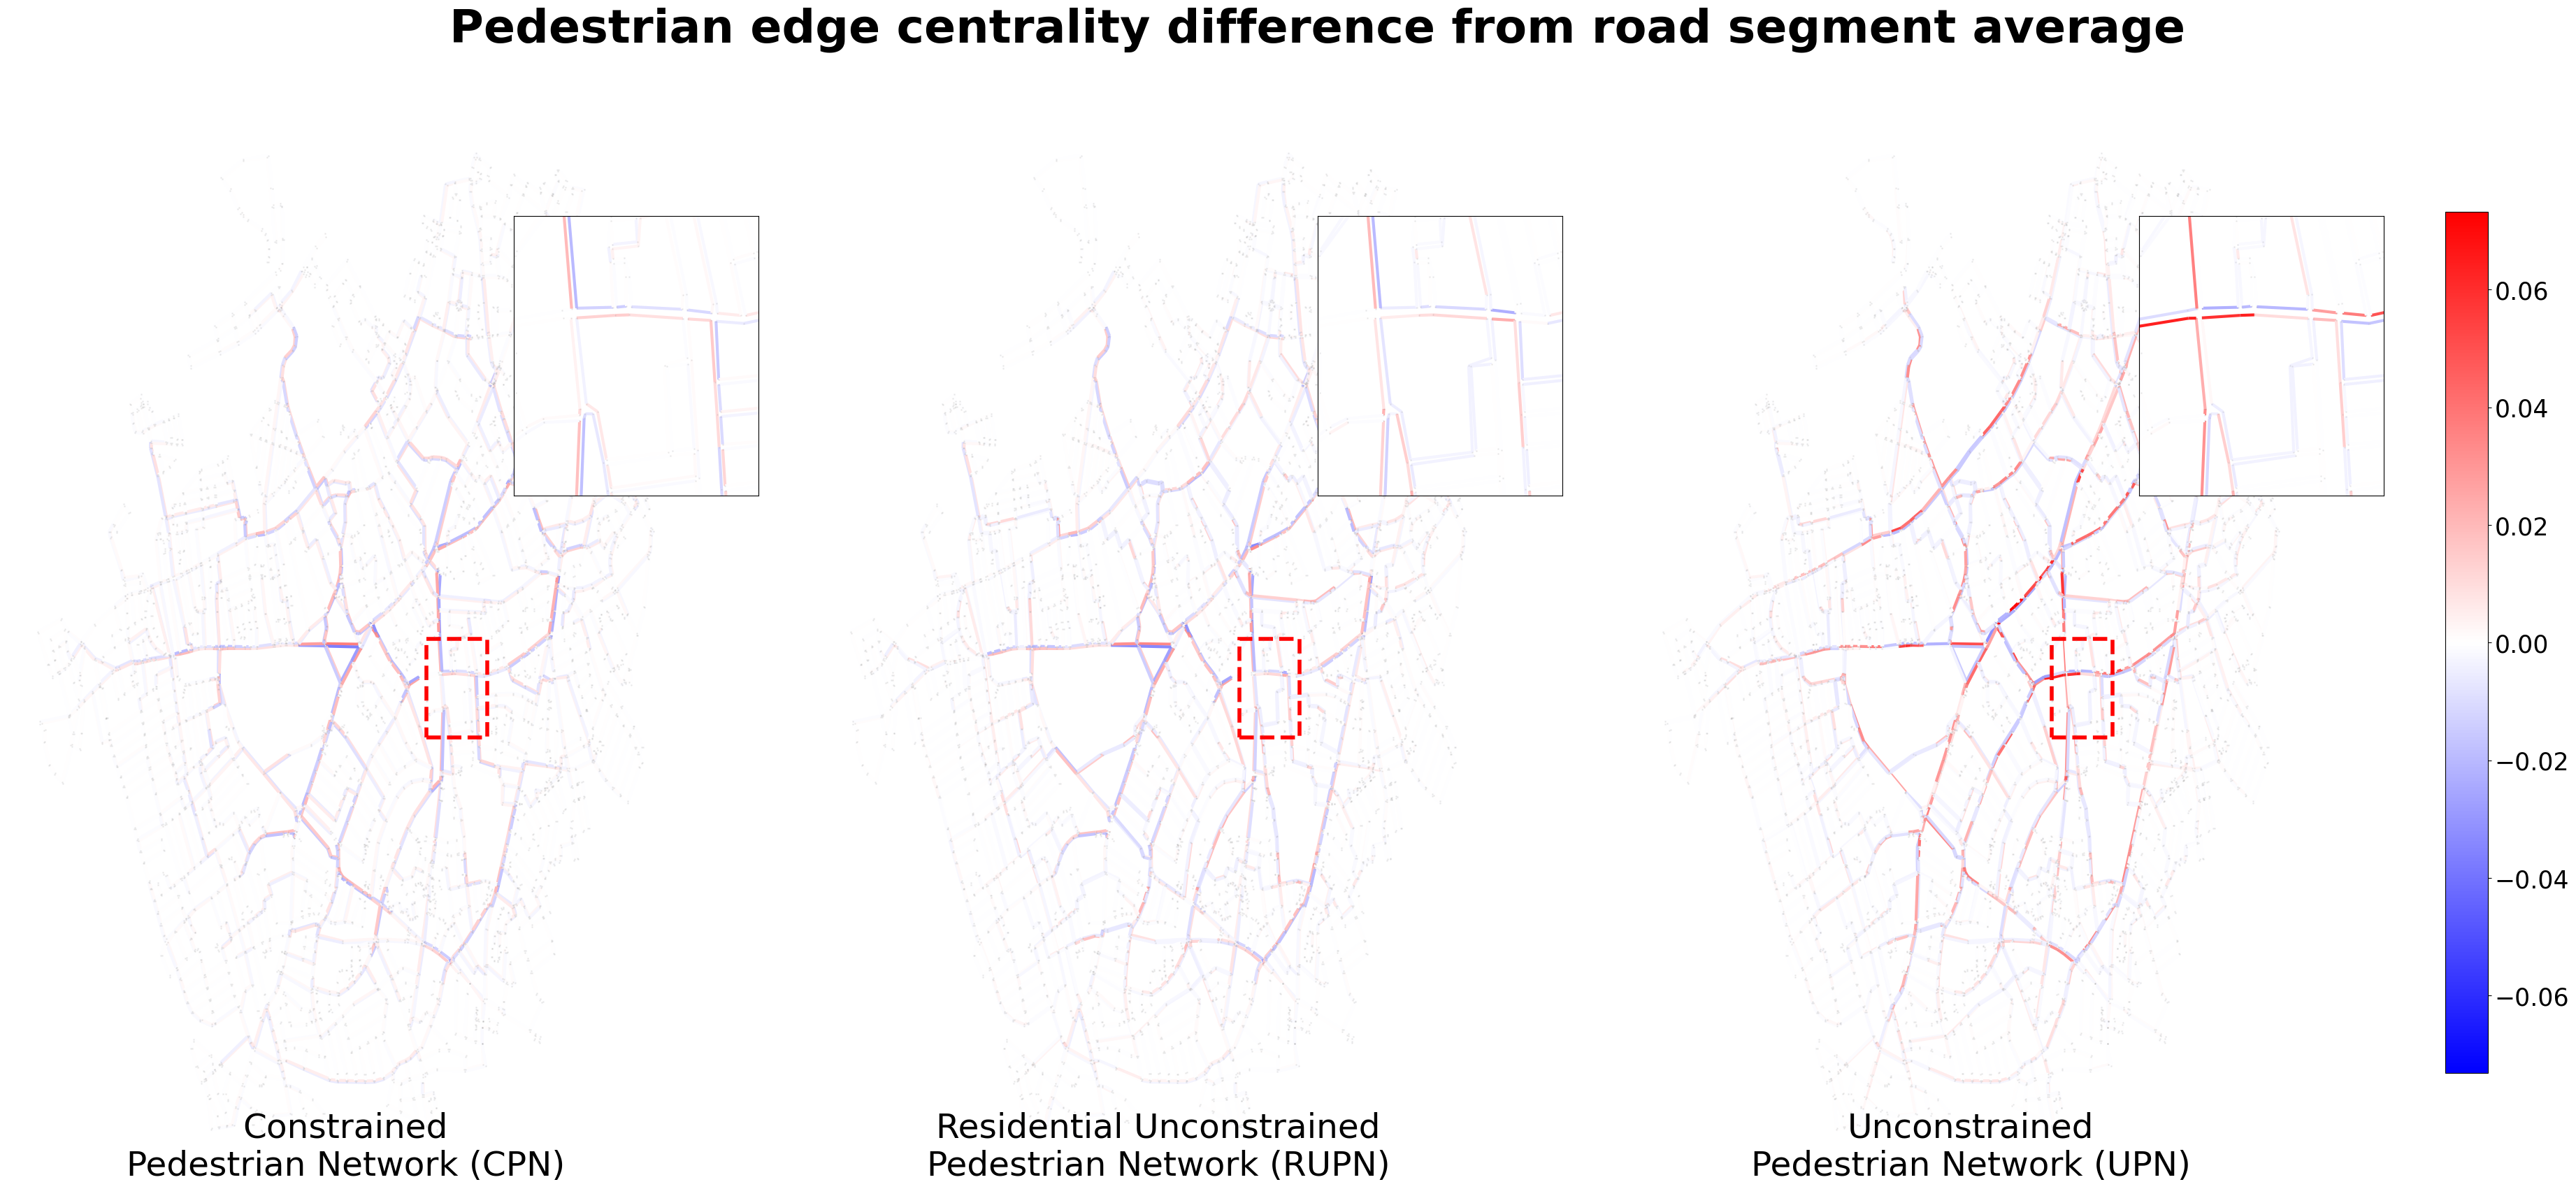

In [182]:
f, axs = plot_disaggregate_bc_values_for_multiple_networks(dict_node_pos, zoom_bb, G_BCDiff, G_BCDiffRes, G_BCDiffExDi, BCDiff = 'paveBCdiff_pv', BCDiffRes = 'paveRBCdiff_pv', BCDiffExDi = 'paveExDBCdiff_pv')

In [183]:
f.savefig(output_network_figure_primal)